# SIT744 Practical 7: Transfer learning 

*Dr Wei Luo*

<div class="alert alert-info">
We suggest that you run this notebook using Google Colab.
</div>


## Pre-practical readings

- [Using a pre-trained convnet](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/first_edition/5.3-using-a-pretrained-convnet.ipynb)



Last week, we train a ConvNet from scratch. In many computer vision applications, you can build a model from a pre-trained model, either as a feature extractor or as part of a new model. We will practice this approach using the cat-vs-dog example last week.








In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

TRAIN_DS_SIZE = 2000
VALID_DS_SIZE = 1000
TEST_DS_SIZE = 1000

(cat_dog_train, cat_dog_valid, cat_dog_test), info = tfds.load('cats_vs_dogs', 
                                                               split=[f'train[:{TRAIN_DS_SIZE}]', 
                                                                      f'train[{TRAIN_DS_SIZE}:{TRAIN_DS_SIZE + VALID_DS_SIZE}]', 
                                                                      f'train[{TRAIN_DS_SIZE + VALID_DS_SIZE}:{TRAIN_DS_SIZE + VALID_DS_SIZE + TEST_DS_SIZE}]'],
                                                               with_info=True,
                                                               as_supervised=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete51JZV6/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


## Task 1 Using models from keras.applications

Many pre-trained models can be found in `keras.applications`. Here we will use a pre-trained [VGG16](https://arxiv.org/abs/1409.1556) model.

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

We can use a pretrained model either as a fixed layer or as part of the model that will be co-trained. Here we use the convolutional base only as a feature extractor. Therefore we keep the network weights frozen.

In [ ]:
conv_base.trainable = False

We see that the model expect the input size to be (150, 150, 3). Therefore we need to resize our image to fit the conv_base.

In [ ]:
IMAGE_SIZE = 150
def pre_process_image(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) ## Instead of manually scale the image, call a `tf.image` tool
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  return image, label

TRAIN_BATCH_SIZE = 32
train_batches = cat_dog_train.map(pre_process_image).batch(TRAIN_BATCH_SIZE).cache().repeat()
validation_batches = cat_dog_valid.map(pre_process_image).batch(TRAIN_BATCH_SIZE).cache().repeat()



The convolution base outputs a feature map of shape (4, 4, 512). It needs to be flattened before feeding to a dense top.

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

def make_model():
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.7))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
                loss='binary_crossentropy',
                metrics=['acc'])

  return model

model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


Now train the new model.

In [ ]:
history = model.fit(
      train_batches,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_batches,
      validation_steps=100
      )

Epoch 1/30
100/100 [==============================] - 22s 223ms/step - loss: 0.6556 - acc: 0.6388 - val_loss: 0.4751 - val_acc: 0.7957
Epoch 2/30
100/100 [==============================] - 20s 196ms/step - loss: 0.4695 - acc: 0.7756 - val_loss: 0.4038 - val_acc: 0.8223
Epoch 3/30
100/100 [==============================] - 20s 198ms/step - loss: 0.3990 - acc: 0.8213 - val_loss: 0.3675 - val_acc: 0.8485
Epoch 4/30
100/100 [==============================] - 20s 198ms/step - loss: 0.3461 - acc: 0.8526 - val_loss: 0.3535 - val_acc: 0.8392
Epoch 5/30
100/100 [==============================] - 20s 198ms/step - loss: 0.3200 - acc: 0.8643 - val_loss: 0.3429 - val_acc: 0.8421
Epoch 6/30
100/100 [==============================] - 20s 198ms/step - loss: 0.3084 - acc: 0.8643 - val_loss: 0.3319 - val_acc: 0.8549
Epoch 7/30
100/100 [==============================] - 20s 199ms/step - loss: 0.2841 - acc: 0.8772 - val_loss: 0.3247 - val_acc: 0.8542
Epoch 8/30
100/100 [==============================] - 2

In [ ]:
%pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-5ghit8vq
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-5ghit8vq
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.07ee881aabb06ba183555e4900b303ef131f3f85c_-cp36-none-any.whl size=98707 sha256=df6b40651effbf9b657ac55d8826f6548ccea83267c3868a9d299e3495adc87d
  Stored in directory: /tmp/pip-ephem-wheel-cache-c7h81xdj/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


(0.0, 1.0)

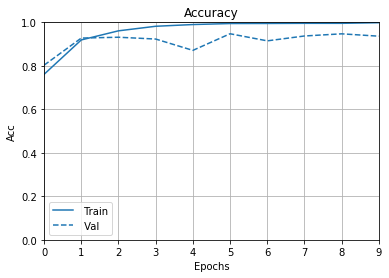

In [ ]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import matplotlib.pyplot as plt

plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"": history}, metric = "acc")
plt.title("Accuracy")
plt.ylim([0,1])

**question** Review the training accuracy from the practical. Compare the accuracy of the above model with the accuracy you obtained when you train a model from scratch. Which one is better?

## Task 2 Fine-tuning a pre-trained model

If you have sufficient training examples and computing resources, you may fine-tune the convolutional base. That is, let some layers in the convolutional base to be jointly trained with the dense top.

We will fine-tune the top 3 layers in Block 5 of VGG.

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model = make_model()
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

fine_tuned_history = model.fit(
       train_batches,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_batches,
      validation_steps=100)

Epoch 1/30
100/100 [==============================] - 22s 221ms/step - loss: 0.6041 - acc: 0.6740 - val_loss: 0.4078 - val_acc: 0.8242
Epoch 2/30
100/100 [==============================] - 22s 218ms/step - loss: 0.3515 - acc: 0.8428 - val_loss: 0.3075 - val_acc: 0.8696
Epoch 3/30
100/100 [==============================] - 22s 221ms/step - loss: 0.2395 - acc: 0.8998 - val_loss: 0.2651 - val_acc: 0.8916
Epoch 4/30
100/100 [==============================] - 22s 220ms/step - loss: 0.1964 - acc: 0.9126 - val_loss: 0.2537 - val_acc: 0.9028
Epoch 5/30
100/100 [==============================] - 22s 221ms/step - loss: 0.1490 - acc: 0.9428 - val_loss: 0.2682 - val_acc: 0.8945
Epoch 6/30
100/100 [==============================] - 22s 220ms/step - loss: 0.1148 - acc: 0.9558 - val_loss: 0.2383 - val_acc: 0.9076
Epoch 7/30
100/100 [==============================] - 22s 221ms/step - loss: 0.0909 - acc: 0.9688 - val_loss: 0.2411 - val_acc: 0.9146
Epoch 8/30
100/100 [==============================] - 2

(0.0, 1.0)

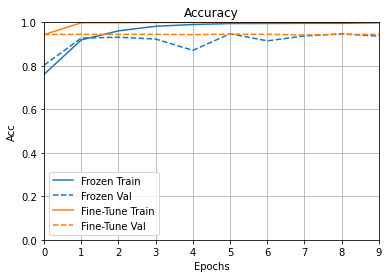

In [ ]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"frozen": history, "fine-tune": fine_tuned_history}, metric = "acc")
plt.title("Accuracy")
plt.ylim([0,1])

**exercise** In the above example, we did not use data augmentation in the training data pipeline. Do you think that data augmentation would help with fine-tuning? Try it out yourself.

## Task 3 Using models from TensorFlow Hub

You can find many more pretrained models in [TensorFlow Hub](https://tfhub.dev/). Here we will use Mobilenet, which is much smaller compared to VGG16.

When you select the models, you need to consider what is the expected image size. Here we use a model of input size (224, 224, 3). Also we only use the model to generate feature vectors. (That is, we use it as a convolutional base.)

There are two ways to load a tfhub model:

- The lower level function `hub.load()`
- The Keras-compatible function `hub.KerasLayer()`

We will use the latter.


In [ ]:
import tensorflow_hub as hub

IMAGE_SIZE = 224

MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"


do_fine_tuning = False 

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMAGE_SIZE, 
                                            IMAGE_SIZE, 
                                            3)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1,
                          activation='sigmoid')
])


model.summary()

                      


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In the above example, we use the `hub.KerasLayer` function to include the pre-trained model. Also note that we supplied an `InputLayer`, which has no weights, to specify the input size. Alternatively, you may use the `model.build()` function to specify the input shape.

Let's redefine the input pipelines using the new IMAGE_SIZE.

In [ ]:
def pre_process_image(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) ## Instead of manually scale the image, call a `tf.image` tool
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  return image, label

TRAIN_BATCH_SIZE = 32
train_batches = cat_dog_train.map(pre_process_image).batch(TRAIN_BATCH_SIZE).cache().repeat()
validation_batches = cat_dog_valid.map(pre_process_image).batch(TRAIN_BATCH_SIZE).cache().repeat()


Now we can compile the model and train it as before.

In [ ]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

mobile_net_history = model.fit(
      train_batches,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_batches,
      validation_steps=100
      )

Epoch 1/30
100/100 [==============================] - 9s 88ms/step - loss: 0.6656 - acc: 0.6027 - val_loss: 0.5907 - val_acc: 0.7091
Epoch 2/30
100/100 [==============================] - 4s 44ms/step - loss: 0.5705 - acc: 0.7030 - val_loss: 0.5119 - val_acc: 0.7896
Epoch 3/30
100/100 [==============================] - 4s 44ms/step - loss: 0.5061 - acc: 0.7688 - val_loss: 0.4430 - val_acc: 0.8501
Epoch 4/30
100/100 [==============================] - 4s 44ms/step - loss: 0.4369 - acc: 0.8428 - val_loss: 0.3849 - val_acc: 0.8929
Epoch 5/30
100/100 [==============================] - 4s 44ms/step - loss: 0.3791 - acc: 0.8916 - val_loss: 0.3352 - val_acc: 0.9284
Epoch 6/30
100/100 [==============================] - 4s 44ms/step - loss: 0.3383 - acc: 0.9040 - val_loss: 0.2938 - val_acc: 0.9520
Epoch 7/30
100/100 [==============================] - 4s 44ms/step - loss: 0.2921 - acc: 0.9293 - val_loss: 0.2590 - val_acc: 0.9610
Epoch 8/30
100/100 [==============================] - 4s 44ms/step - 

(0.0, 1.0)

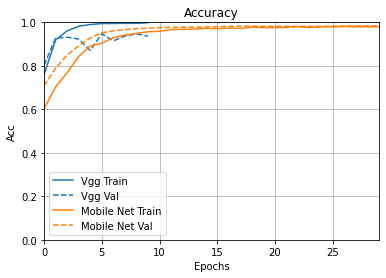

In [ ]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"vgg": history, "mobile net": mobile_net_history}, metric = "acc")
plt.title("Accuracy")
plt.ylim([0,1])

(0.0, 1.0)

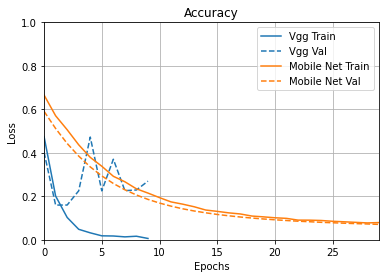

In [ ]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"vgg": history, "mobile net": mobile_net_history}, metric = "loss")
plt.title("Accuracy")
plt.ylim([0,1])

As you can see, MobileNet achieved a much higher accuracy.

**exercise** Visit the [TensorFlow Hub](https://tfhub.dev/) to see what other pretrained models are available. For each model, see what is the expected input shape. Follow the example above to try out some other models. 

## Additional resources

- [Transfer learning with TensorFlow Hub](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub)
- [TensorFlow 2 SavedModels](https://www.tensorflow.org/hub/tf2_saved_model)